based on https://arxiv.org/pdf/1611.01578.pdf

at every step, the RNN outputs two vectors, representing probability distributions for
 - type of layer: can be fully connected, skip connection, dropout, or end of network
 - argument for the layer: can be dropout probability, number of layers to skip (backwards), or number of neurons

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd

In [49]:
class ControllerRNN:
    def __init__(self, max_len, batch_size, type_size, arg_size,
                 learning_rate=0.001, hidden_size=32, baseline_smoothing=0.95):
        self.hidden_size = hidden_size
        self.unroll_by = max_len
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.type_size = type_size + 1  # 0 is for end-of-network token
        self.arg_size = arg_size
        self.baseline_smoothing = baseline_smoothing

    def build(self):
        # reward for the architectures
        self.architecture_reward = tf.placeholder(tf.float32, [self.batch_size])
        
        # exponential moving average of the reward
        self.last_average_reward = tf.reduce_mean(self.architecture_reward)
        self.reward_ema = tf.train.ExponentialMovingAverage(self.baseline_smoothing)
        self.update_reward_ema = self.reward_ema.apply([self.last_average_reward])

        rnn = tf.contrib.rnn.GRUCell(self.hidden_size)
        state = tf.random_normal([self.batch_size, rnn.state_size])
        
        # weight matrices to transform from rnn output to layer type and discrete arg
        rnn_to_layer_type_weight = tf.Variable(tf.random_normal([rnn.output_size, self.type_size]))
        rnn_to_layer_type_gradient = []
        rnn_to_layer_arg_weight = tf.Variable(tf.random_normal([rnn.output_size, self.arg_size]))
        rnn_to_layer_arg_gradient = []

        # rnn output and gradients
        output = tf.random_normal([self.batch_size, rnn.output_size])

        # layer_probs contains the output from the network, namely the probabilities
        # of type and argument for every layer of every network
        self.layer_probs = []

        # layer_indicators contains one-hot indicators of type and argument
        # for every layer of every network.
        # used to select which action is used to compute the gradient.
        # fixed, must be set before updating the weights
        self.layer_indicators = []

        losses = []
        
        for i in range(self.unroll_by):
            # run rnn cell
            output, state = rnn(output, state)

            if i == 0:  # gru variables are only initialized now
                rnn_params = rnn.trainable_variables + rnn.trainable_weights
                rnn_gradients = [[] for _ in range(len(rnn_params))]

            # compute output probabilites
            layer_type = tf.nn.softmax(tf.matmul(output, rnn_to_layer_type_weight))
            layer_arg = tf.nn.softmax(tf.matmul(output, rnn_to_layer_arg_weight))
            chosen_layer_type = tf.placeholder(tf.int32, self.batch_size)
            chosen_layer_arg = tf.placeholder(tf.int32, self.batch_size)
            self.layer_probs.append((layer_type, layer_arg))
            self.layer_indicators.append((chosen_layer_type, chosen_layer_arg))

            # aggregate gradients
            baseline = self.reward_ema.average(self.last_average_reward)
            prob = (self.last_average_reward - baseline) * (
                tf.reduce_sum(
                    tf.one_hot(chosen_layer_type, depth=self.type_size) * tf.log(layer_type + 1e-12),
                    axis=1
                ) + tf.reduce_sum(
                    tf.one_hot(chosen_layer_arg, depth=self.arg_size) * tf.log(layer_arg + 1e-12),
                    axis=1
                )
            )
            losses.append(prob)

            rnn_to_layer_arg_gradient.append(tf.gradients(prob, rnn_to_layer_arg_weight)[0])
            rnn_to_layer_type_gradient.append(tf.gradients(prob, rnn_to_layer_type_weight)[0])
            for param, grad in zip(rnn_params, rnn_gradients):
                grad.append(tf.gradients(prob, param)[0])

        self.loss = tf.reduce_mean(losses)

        def sanitize_gradient(grads):
            avg = sum(grads) / len(grads)
            return tf.clip_by_norm(avg, 1.0)

        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.optimize = optimizer.apply_gradients([
            (sanitize_gradient(grad), param)
            for param, grad in zip(rnn_params, rnn_gradients)
        ] + [
            (sanitize_gradient(rnn_to_layer_type_gradient), rnn_to_layer_type_weight),
            (sanitize_gradient(rnn_to_layer_arg_gradient), rnn_to_layer_arg_weight),
        ])

    def generate_architecture(self, session):
        layers = session.run(self.layer_probs)
        networks = [[] for _ in range(self.batch_size)]
        for (ltype, larg) in layers:
            for i, (nnet, type_prob, arg_prob) in enumerate(zip(networks, ltype, larg)):
                # the network always has at least one layer
                if nnet and nnet[-1][0] == 0:
                    continue

                assert all(np.isfinite(type_prob))
                assert all(np.isfinite(arg_prob))

                layer_type = np.random.choice(len(type_prob), p=type_prob)
                layer_arg = np.random.choice(len(arg_prob), p=arg_prob)
                nnet.append((layer_type, layer_arg))

        return networks

    def learn_from_rewards(self, sess, networks, rewards):
        assert len(rewards) == self.batch_size

        # set the indicator variables, telling which action was chosen
        feed_dict = {ind: []
                     for layer_ind in self.layer_indicators
                     for ind in layer_ind}

        for nnet in networks:
            # pad network if shorter than expected
            # we set the indicators to -1, so that all one hot will be 0
            # thus not contributing to the gradient
            if len(nnet) < self.unroll_by:
                nnet = nnet + [(-1, -1)] * (self.unroll_by - len(nnet))

            assert len(nnet) == self.unroll_by
            for (itype, iarg), (ntype, narg) in zip(self.layer_indicators, nnet):
                feed_dict[itype].append(ntype)
                feed_dict[iarg].append(narg)

        feed_dict[self.architecture_reward] = rewards
        loss, _, _ = sess.run([self.loss, self.update_reward_ema, self.optimize],
                              feed_dict=feed_dict)
        return loss

we can test this controller with a very simple and quick task: generate a 4 layer neural network with the following layer arguments: $(4,3,2,1)$ and the following layer types: $(1,2,1,2)$. the goodness of a candidate architecture is simply the mean squared error between it and the target architecture

In [81]:
def evaluate_architecture(arch):
    target_depth = 4
    
    target_arch = np.zeros((controller.unroll_by, 2))
    target_arch[:target_depth, 0] = [1 + i % 2 for i in range(target_depth)]
    target_arch[:target_depth, 1] = [target_depth - i + 1 for i in range(target_depth)]

    full_arch = np.zeros((controller.unroll_by, 2))
    full_arch[:len(arch), :] = arch

    return np.mean((full_arch - target_arch)**2)

controller = ControllerRNN(
    max_len=10,
    batch_size=2,
    type_size=2,
    arg_size=10,
    learning_rate=0.001,
    baseline_smoothing=0.9,
)

hist = []
with tf.Graph().as_default():
    controller.build()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        rs = []
        for i in range(10000):
            networks = controller.generate_architecture(sess)
            rewards = list(map(evaluate_architecture, networks))
            loss = controller.learn_from_rewards(sess, networks, rewards)
            
            rs.extend(rewards)
            if i % 100 == 0:
                hist.append((np.mean(rs), loss**2))
                print(i, hist[-1])
                rs = []

clear_output()

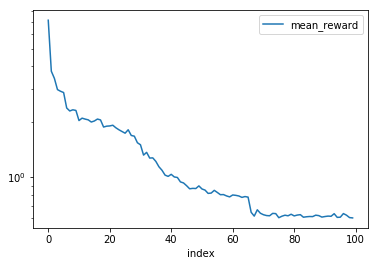

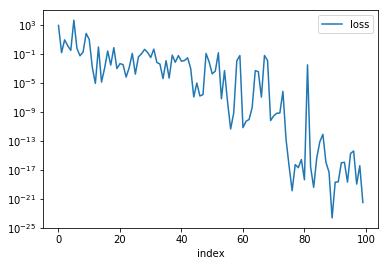

In [82]:
res = pd.DataFrame(hist, columns=('mean_reward', 'loss')).reset_index()
res.plot('index', 'mean_reward', logy=True)
res.plot('index', 'loss', logy=True)

awesome

we can try building a real neural network, then! for simplicity, we ignore the layer type, since we test on a very simple problem, and use only fully connected layers.

we create 10 independent and normally distributed features, and compute the output using only two of them. this creates high risk of overfitting, because random networks are too big and do not generalize. in fact, a simple network with one hidden layer of 5 neurons easily achieves 0.001 validation mse, whereas a 4 hidden layers network overfits and gets stuck at 0.2

In [119]:
def target_function(x, y):
    return np.sin(x) * np.cos(y)# + np.random.normal(scale=0.001, size=len(x))

data_x = np.random.normal(size=(100, 5))
data_y = target_function(data_x[:, 0], data_x[:, 1])

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2)

In [137]:
class SimpleFCNetwork:
    def __init__(self):
        self.learning_rate = 0.01

    def make_weights(self, rows, cols, mag=0.1):
        weights = tf.Variable(tf.random_uniform([rows, cols], -mag, mag))
        bias = tf.Variable(tf.constant(mag * (2 * np.random.random() - 1), shape=[1, cols]))
        self.variables.append(weights)
        self.variables.append(bias)
        return weights, bias

    @staticmethod
    def compute_next_layer(input_layer, weights, bias, activation=tf.nn.relu):
        h = tf.matmul(input_layer, weights) + bias
        output = activation(h) if activation else tf.identity(h)
        return output

    def build(self, input_shape, layers):
        self.input = tf.placeholder(tf.float32, [None, input_shape])
        self.label = tf.placeholder(tf.float32, [None, 1])

        self.variables = []
        last_layer, last_size = self.input, input_shape
        for layer_type, layer_arg in layers:
            if layer_type == 1:
                ws, bs = self.make_weights(last_size, layer_arg)
                last_layer = self.compute_next_layer(last_layer, ws, bs)
                last_size = layer_arg
            else:
                last_layer = tf.nn.dropout(
                    last_layer, keep_prob=(layer_arg + 1) / 10
                )

        ws, bs = self.make_weights(last_size, 1)
        self.output = self.compute_next_layer(last_layer, ws, bs, activation=None)
        self.loss = tf.reduce_mean(tf.squared_difference(self.output, self.label))
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.optimize = optimizer.minimize(self.loss)
        
        return self

    def train_on_batch(self, sess, batch_x, batch_y):
        loss, _ = sess.run([self.loss, self.optimize], feed_dict={
            self.input: batch_x,
            self.label: batch_y.reshape(-1, 1),
        })
        return loss

    def test_on_batch(self, sess, batch_x, batch_y):
        return sess.run(self.loss, feed_dict={
            self.input: batch_x,
            self.label: batch_y.reshape(-1, 1),
        })


def evaluate_architecture(sess, nnet, batch_size=32, max_epochs=100, verbose=0):
    for ep in range(max_epochs):
        # perform a full epoch on training data
        sh_train_x, sh_train_y = shuffle(train_x, train_y)
        for batch_start in range(0, train_x.shape[0], batch_size):
            ll = nnet.train_on_batch(
                sess,
                sh_train_x[batch_start:batch_start + batch_size],
                sh_train_y[batch_start:batch_start + batch_size],
            )
        
        # evaluate on test data
        val_err = np.mean([
            nnet.test_on_batch(
                sess,
                test_x[batch_start:batch_start + batch_size],
                test_y[batch_start:batch_start + batch_size],
            ) for batch_start in range(0, test_x.shape[0], batch_size)
        ])
        
        if verbose > 0:
            print(ep, val_err)
    
    return val_err


with tf.Graph().as_default():
    small_nnet = SimpleFCNetwork().build(train_x.shape[1], [(1, 5)])
    large_nnet = SimpleFCNetwork().build(train_x.shape[1], [(1, 10) for i in range(6)])
    
    with tf.Session() as sess:
        initializer = tf.global_variables_initializer()
        sess.run(initializer)

        print('small network', evaluate_architecture(sess, small_nnet))
        print('large network', evaluate_architecture(sess, large_nnet))

small network 0.033418138
large network 0.25767133


In [138]:
class MovingAverages:
    def __init__(self):
        self.metrics = {}
        self.smoothing = {}
    
    def update(self, metric, value, smoothing=None):
        if smoothing is None:
            smoothing = self.smoothing.get(metric, 0.6)
        self.smoothing[metric] = smoothing
        
        # can pass None to update smoothing
        if value is not None:
            self.metrics[metric] = (
                smoothing * self.metrics.get(metric, value)
                + (1 - smoothing) * value
            )
        return self.metrics[metric]
    
    def update_all(self, **metrics):
        for metric, value in metrics.items():
            self.update(metric, value)
        return [self.metrics[m] for m in metrics]

In [ ]:
controller = ControllerRNN(
    hidden_size=64,
    max_len=5,
    batch_size=2,
    type_size=2,
    arg_size=10,
    learning_rate=0.001,
    baseline_smoothing=0.99,
)


hist = []
controller_graph = tf.Graph()
with controller_graph.as_default():
    controller.build()
    controller_session = tf.Session(graph=controller_graph)
    controller_session.run(tf.global_variables_initializer())

averages = MovingAverages()
for i in range(10000):
    architectures = controller.generate_architecture(controller_session)

    # test architectures on a temporary graph
    with tf.Graph().as_default():
        networks = [
            SimpleFCNetwork().build(train_x.shape[1], arch)
            for arch in architectures
        ]

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            rewards = [
                evaluate_architecture(
                    sess, nnet, verbose=0
                ) for nnet in networks
            ]

    loss = controller.learn_from_rewards(
        controller_session, architectures, rewards
    )

    averages.update_all(
        controller_loss=loss**2,
        inner_mse=np.mean(rewards),
        inner_mse_std=np.std(rewards),
        length=np.mean(list(map(len, architectures))),
        size=np.mean([sum(n for _, n in arch) for arch in architectures]),
    )

    if i % 25 == 0:
        print(i, '\t', '\t'.join(
            '%s=%.3f' % metric for metric in averages.metrics.items()
        ))

0 	 controller_loss=1.747	inner_mse=0.184	inner_mse_std=0.074	length=3.000	size=22.000
25 	 controller_loss=7.798	inner_mse=0.216	inner_mse_std=0.024	length=3.393	size=13.802
50 	 controller_loss=5.157	inner_mse=0.264	inner_mse_std=0.079	length=3.612	size=13.699
75 	 controller_loss=0.882	inner_mse=0.212	inner_mse_std=0.042	length=3.479	size=11.084
100 	 controller_loss=0.864	inner_mse=0.222	inner_mse_std=0.028	length=2.880	size=10.473
125 	 controller_loss=0.220	inner_mse=0.200	inner_mse_std=0.041	length=2.862	size=14.784
150 	 controller_loss=0.293	inner_mse=0.178	inner_mse_std=0.034	length=3.616	size=23.344
175 	 controller_loss=0.265	inner_mse=0.165	inner_mse_std=0.051	length=1.674	size=6.859
200 	 controller_loss=0.230	inner_mse=0.197	inner_mse_std=0.027	length=3.559	size=23.061
225 	 controller_loss=0.342	inner_mse=0.188	inner_mse_std=0.064	length=3.515	size=15.546
250 	 controller_loss=0.483	inner_mse=0.241	inner_mse_std=0.015	length=3.888	size=11.484
275 	 controller_loss=0.087